In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir="Teeth_Dataset"
Training_Dataset=keras.utils.image_dataset_from_directory(
    data_dir+"/Training",
    labels="inferred",
    image_size=(64,64),
    label_mode="categorical",
    batch_size=16
)
Validation_Dataset=keras.utils.image_dataset_from_directory(
    data_dir+"/Validation",
    labels="inferred",
        image_size=(64,64),

    label_mode="categorical",
    batch_size=16
)
Testing_Dataset=keras.utils.image_dataset_from_directory(
    data_dir+"/Testing",
    labels="inferred",
        image_size=(64,64),

    label_mode="categorical",
    batch_size=16
)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


[480 450 360 540 324 540 393]


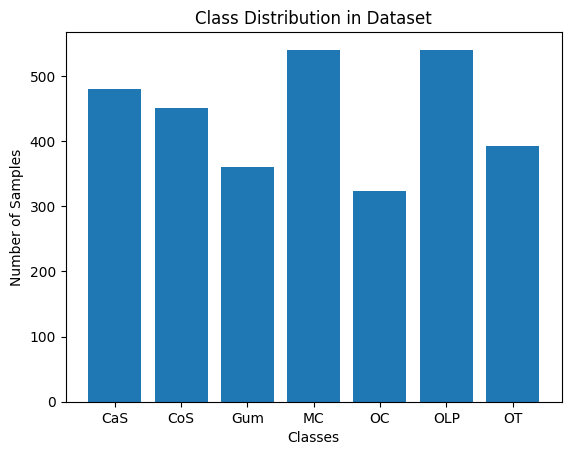

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def getCounts(dataset):
    y_train = []
    for images, labels in dataset:
        # print(labels.numpy())
        index=np.argmax(labels.numpy(), axis=1)
        # print(index)
        y_train.extend(index)
        counts = np.bincount(y_train)
    return counts    


counts = getCounts(Training_Dataset)
print(counts)
plt.figure()
plt.bar(Training_Dataset.class_names, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Dataset")
plt.show()

In [4]:
from keras.callbacks import EarlyStopping , ModelCheckpoint

early_stop=EarlyStopping(monitor='val_loss',patience=4, restore_best_weights=True)

callbacks=ModelCheckpoint('my_model.keras', monitor='val_loss', save_best_only=True)

In [5]:
from tensorflow.keras import layers

# 1. Define the augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
], name="data_augmentation")

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime

# Create a unique folder for logs
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,   # optional: logs weights & activations
    write_graph=True,   # optional: saves model graph
    write_images=True   # optional: saves weights as images
)


In [7]:
history = model.fit(
    Training_Dataset,
    validation_data=Validation_Dataset,
    epochs=40,  # at least 1 epoch
    callbacks=[tensorboard_cb, early_stop, callbacks]
)


Epoch 1/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1775 - loss: 1.9298 - val_accuracy: 0.2101 - val_loss: 1.8655
Epoch 2/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2702 - loss: 1.8159 - val_accuracy: 0.3726 - val_loss: 1.6871
Epoch 3/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3401 - loss: 1.6985 - val_accuracy: 0.3375 - val_loss: 1.6798
Epoch 4/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3729 - loss: 1.6292 - val_accuracy: 0.4018 - val_loss: 1.5849
Epoch 5/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4085 - loss: 1.5536 - val_accuracy: 0.4465 - val_loss: 1.4701
Epoch 6/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4441 - loss: 1.4732 - val_accuracy: 0.4319 - val_loss: 1.5174
Epoch 7/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4535 - loss: 1.4410 - val_accuracy: 0.5039 - val_loss: 1.3626
Epoch 8/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4823 - loss: 1.3619 - val_accu

In [8]:
# def normalize(images, labels):
#     return images / 255.0, labels
# Testing_Dataset = Testing_Dataset.map(normalize)
eval = model.evaluate(Testing_Dataset)
print(f"Test Loss: {eval[0]}, Test Accuracy: {eval[1]}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7850 - loss: 0.6499
Test Loss: 0.6498792767524719, Test Accuracy: 0.7850194573402405


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
y_true=[]
y_pred=[]
for images,labels in Testing_Dataset:
    predictions=model.predict(images)
    # print(predictions)
    y_true.extend(np.argmax(labels.numpy(),axis=1))
    y_pred.extend(np.argmax(predictions,axis=1))

print(classification_report(y_true, y_pred, target_names=Testing_Dataset.class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

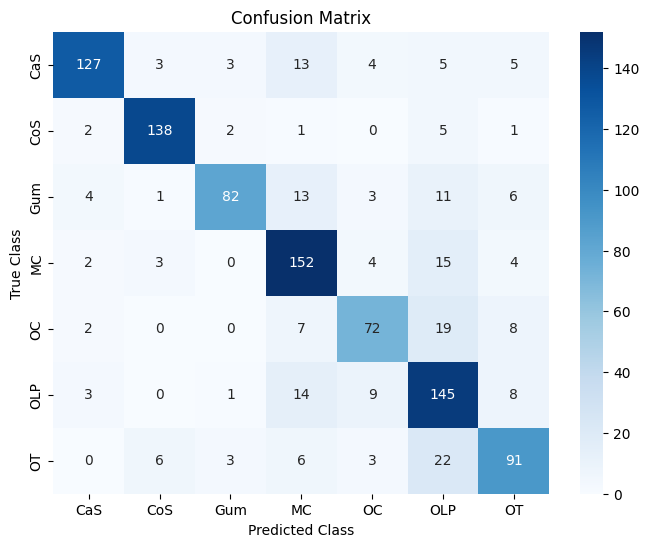

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = Testing_Dataset.class_names  

# Assuming y_true and y_pred are already filled
y_true_classes = [class_names[i] for i in y_true]
y_pred_classes = [class_names[i] for i in y_pred]


# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=class_names)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()



In [11]:
image=plt.imread("Teeth_Dataset/Testing/Gum/g_1200_0_2341.jpg")
image = tf.image.resize(image, (64, 64))
image = image / 255.0 
# print(image)
predictions=model.predict(np.expand_dims(image, axis=0))
predicted_class = np.argmax(predictions)
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0


In [23]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit --port 6005
# localhost:6005

Reusing TensorBoard on port 6005 (pid 22508), started 0:01:07 ago. (Use '!kill 22508' to kill it.)